In [85]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sn
from numpy import array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [86]:
def run_task_1(training_images, testing_images, labels):
    #Construct network model
    task1_model = Sequential()
    task1_model.add(layers.Dense(units=1024,input_shape=(1024,), activation='tanh'))
    task1_model.add(layers.Dense(units=512, activation='sigmoid'))
    task1_model.add(layers.Dense(units=100, activation='relu'))
    task1_model.add(layers.Dense(units=7, activation='softmax'))
    
    #Create and fit the one hot encoder
    enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
    encoded_labels = enc.fit_transform(labels)
     
    #Create and fit the scaler to the data
    scaler = MinMaxScaler()
    scaled_training_images=scaler.fit_transform(training_images)
    scaled_testing_images=scaler.transform(testing_images)
    task1_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    task1_model.fit(x=scaled_training_images,y=encoded_labels, epochs=15, validation_split=0.2)
    cm = task1_model.predict(x=scaled_testing_images)
    print(len(cm))
    sn.heatmap(cm, annot=False)
    
    return task1_model

In [87]:
#read in training and testing csv with labels for our data
training_df = pd.read_csv('fairface_label_train.csv', nrows=1000)
training_df=training_df.drop('file',axis=1) 
training_df=training_df.drop('service_test',axis=1)
training_df=training_df.drop('age',axis=1)

#training_df=training_df.drop('race',axis=1)
training_df=training_df.drop('gender', axis=1)

print(training_df.head())

testing_df = pd.read_csv('fairface_label_val.csv', nrows=1000)

#read in images that we will be predicting on
training_images = np.empty(shape=(1000,1024))
for i in range(1, 1001):
    f_string = 'train/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    im = im.flatten()
    training_images[i-1]=im
    
testing_images = np.empty(shape=(1000,1024))
for i in range(1, 1001):
    f_string = 'val/' + str(i) + '.jpg'
    im = Image.open(f_string)
    im = np.array(im)
    im = im.flatten()
    testing_images[i-1]=im

         race
0  East Asian
1      Indian
2       Black
3      Indian
4      Indian


Epoch 1/15
25/25 [==============================] - 1s 26ms/step - loss: 1.9427 - accuracy: 0.1825 - val_loss: 1.9612 - val_accuracy: 0.1400
Epoch 2/15
25/25 [==============================] - 0s 16ms/step - loss: 1.9278 - accuracy: 0.1813 - val_loss: 1.9226 - val_accuracy: 0.1650
Epoch 3/15
25/25 [==============================] - 0s 13ms/step - loss: 1.9198 - accuracy: 0.2000 - val_loss: 1.9225 - val_accuracy: 0.1850
Epoch 4/15
25/25 [==============================] - 0s 11ms/step - loss: 1.9193 - accuracy: 0.1863 - val_loss: 1.9166 - val_accuracy: 0.1750
Epoch 5/15
25/25 [==============================] - 0s 9ms/step - loss: 1.9106 - accuracy: 0.1937 - val_loss: 1.9030 - val_accuracy: 0.1650
Epoch 6/15
25/25 [==============================] - 0s 9ms/step - loss: 1.9082 - accuracy: 0.2075 - val_loss: 1.8868 - val_accuracy: 0.2750
Epoch 7/15
25/25 [==============================] - 0s 11ms/step - loss: 1.9051 - accuracy: 0.2100 - val_loss: 1.9182 - val_accuracy: 0.1450
Epoch 8/15
25/2

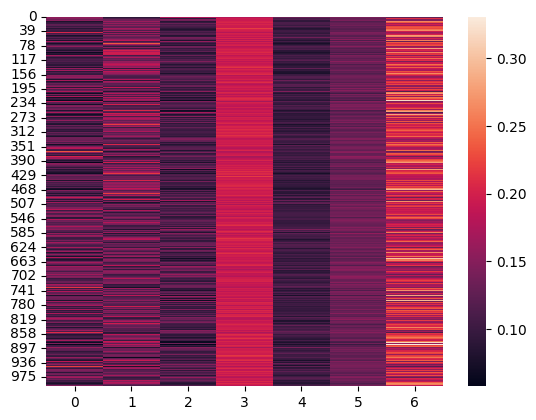

In [88]:
mod = run_task_1(training_images=training_images, testing_images=testing_images, labels=training_df)